# SPIN

In [1]:
!pwd

/home/Sketch-Based-Modelling


In [2]:
import torch
from torchvision.transforms import Normalize, ToPILImage
import numpy as np
import cv2
import argparse
import json

from spin.models import hmr, SMPL
from spin.utils.imutils import crop
from spin.utils.renderer import Renderer
import spin.config
import spin.constants

def bbox_from_openpose(openpose_file, rescale=1.2, detection_thresh=0.2):
    """Get center and scale for bounding box from openpose detections."""
    with open(openpose_file, 'r') as f:
        keypoints = json.load(f)['people'][0]['pose_keypoints_2d']
    keypoints = np.reshape(np.array(keypoints), (-1,3))
    valid = keypoints[:,-1] > detection_thresh
    valid_keypoints = keypoints[valid][:,:-1]
    center = valid_keypoints.mean(axis=0)
    bbox_size = (valid_keypoints.max(axis=0) - valid_keypoints.min(axis=0)).max()
    # adjust bounding box tightness
    scale = bbox_size / 200.0
    scale *= rescale
    return center, scale

def bbox_from_json(bbox_file):
    """Get center and scale of bounding box from bounding box annotations.
    The expected format is [top_left(x), top_left(y), width, height].
    """
    with open(bbox_file, 'r') as f:
        bbox = np.array(json.load(f)['bbox']).astype(np.float32)
    ul_corner = bbox[:2]
    center = ul_corner + 0.5 * bbox[2:]
    width = max(bbox[2], bbox[3])
    scale = width / 200.0
    # make sure the bounding box is rectangular
    return center, scale

def process_image_spin(img_file, bbox_file, openpose_file, input_res=224):
    """Read image, do preprocessing and possibly crop it according to the bounding box.
    If there are bounding box annotations, use them to crop the image.
    If no bounding box is specified but openpose detections are available, use them to get the bounding box.
    """
    normalize_img = Normalize(mean=spin.constants.IMG_NORM_MEAN, std=spin.constants.IMG_NORM_STD)
    img = cv2.imread(img_file)[:,:,::-1].copy() # PyTorch does not support negative stride at the moment
    if bbox_file is None and openpose_file is None:
        # Assume that the person is centerered in the image
        height = img.shape[0]
        width = img.shape[1]
        center = np.array([width // 2, height // 2])
        scale = max(height, width) / 200
    else:
        if bbox_file is not None:
            center, scale = bbox_from_json(bbox_file)
        elif openpose_file is not None:
            center, scale = bbox_from_openpose(openpose_file)
    img = crop(img, center, scale, (input_res, input_res))
    img = img.astype(np.float32) / 255.
    img = torch.from_numpy(img).permute(2,0,1)
    norm_img = normalize_img(img.clone())[None]
    return img, norm_img



# gesture-2d-pose-extimation

In [3]:
import urllib
from pathlib import Path
from textwrap import dedent

import cv2
import PIL.Image as Image
import requests

from g2pe.src.utils import get_final_preds, get_input, put_kps, KPS, SKELETON


ROOT_PATH = Path("g2pe/")
ASSETS_PATH = ROOT_PATH / "assets"
DESIRED_SIZE = 512
DEFAULT_IMG_FILEPATH = ASSETS_PATH / "test.png"
DEFAULT_IMG_URLPATH = (
    "https://drawpaintacademy.com/wp-content/uploads/2018/05/Michelangelo.jpg"
)
MODEL_FILEPATH = ASSETS_PATH / "model_best.onnx"
MODEL_URLPATH = (
    f"https://github.com/kbrodt/gesture-2d-pose-estimation/releases/download/v0.1/{MODEL_FILEPATH.name}"
)

def process_image(img_raw):
    if not MODEL_FILEPATH.exists():
        urllib.request.urlretrieve(MODEL_URLPATH, MODEL_FILEPATH)

    model = cv2.dnn.readNetFromONNX(str(MODEL_FILEPATH))

    pose_input, img, center, scale = get_input(img_raw)
    model.setInput(pose_input[None])
    predicted_heatmap = model.forward()
    predicted_keypoints, confidence = get_final_preds(
        predicted_heatmap, center[None], scale[None], post_process=True
    )

    predicted_keypoints, confidence, predicted_heatmap = (
        predicted_keypoints[0],
        confidence[0],
        predicted_heatmap[0],
    )

    img = Image.fromarray(img[..., ::-1])
    original_img_size = img.size
    ratio = float(DESIRED_SIZE) / max(original_img_size)
    resized_img_size = tuple([int(x * ratio) for x in original_img_size])
    img = img.resize(resized_img_size, Image.ANTIALIAS)
    original_img_size = max(original_img_size)

    predicted_keypoints *= (DESIRED_SIZE - 1) / (original_img_size - 1)

    predicted_heatmap = predicted_heatmap.sum(0)
    predicted_heatmap_min = predicted_heatmap.min()
    predicted_heatmap_max = predicted_heatmap.max()
    predicted_heatmap = (predicted_heatmap - predicted_heatmap_min) / (
        predicted_heatmap_max - predicted_heatmap_min
    )
    predicted_heatmap = Image.fromarray((predicted_heatmap * 255).astype("uint8"))
    predicted_heatmap = predicted_heatmap.resize(resized_img_size, Image.ANTIALIAS)

    return img, predicted_keypoints, confidence, predicted_heatmap

# Вспомогательные функции

In [4]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import PIL.ImageDraw as ImageDraw

KPS_SPIN_MAP={
    'Head' : 'Head (H36M)', 
    'Neck' : 'OP Neck',
    'Right Shoulder' : 'OP RShoulder',
    'Right Arm' : 'OP RElbow',
    'Right Hand' : 'OP RWrist',
    'Left Shoulder' : 'OP LShoulder',
    'Left Arm' : 'OP LElbow',
    'Left Hand' : 'OP LWrist',
    'Spine' : 'Spine (H36M)',
    'Hips' : 'OP MidHip',
    'Right Upper Leg' : 'OP RHip',
    'Right Leg' : 'OP RKnee',
    'Right Foot' : 'OP RAnkle',
    'Left Upper Leg' : 'OP LHip',
    'Left Leg' : 'OP LKnee',
    'Left Foot' : 'OP LAnkle'
}
names = list(KPS_SPIN_MAP.keys())

idxs = []
for key in KPS_SPIN_MAP:
    tmp = spin.constants.JOINT_NAMES.index(KPS_SPIN_MAP[key])
    idxs.append(tmp)

In [5]:
def get_pred_and_data(image_path, model_hmr):

    
    # use spin model => joints_pred_2d
    img_sp, norm_img = process_image_spin(image_path, None, None, input_res=spin.constants.IMG_RES)
    pred_rotmat, pred_betas, pred_camera = model_hmr(norm_img.to(device))
    pred_output = smpl(betas=pred_betas, body_pose=pred_rotmat[:,1:], 
                       global_orient=pred_rotmat[:,0].unsqueeze(1), pose2rot=False)
    pred_vertices = pred_output.vertices

    joints_pred_3d = pred_output.joints
    joints_pred_2d = joints_pred_3d[0,:,:2]
    pred_camera = pred_camera.detach()
    coef = pred_camera[:,0]
    camera_translation = torch.stack([pred_camera[:,1], pred_camera[:,2], 2*spin.constants.FOCAL_LENGTH/(spin.constants.IMG_RES * pred_camera[:,0] +1e-9)],dim=-1)
    camera_translation = camera_translation[0].cpu().numpy()

    #scale to img_sp
    img_array = np.asarray(img_sp)
    (m, n) = (img_array.shape[1],img_array.shape[2])
    joints_pred_2d_scaled = joints_pred_2d
    joints_pred_2d_scaled[:,0] = m/2 * (coef*(joints_pred_2d_scaled[:,0]+camera_translation[0]) + 1)
    joints_pred_2d_scaled[:,1] = n/2 * (coef*(joints_pred_2d_scaled[:,1]+camera_translation[1]) + 1)

    # use 2d keypoints detection
    with open(image_path, "br") as inp:
        img_raw = inp.read()
    img_kp, predicted_keypoints, confidence, predicted_heatmap = process_image(img_raw)

    # scale to img_sp
    m1,n1 = np.asarray(img_kp).shape[:2]
    size_sp = m,n
    size_kp = m1,n1
    if (m1>n1): # vertically
        ax1=1
        ax2=0
    else: # horizontal
        ax1=0
        ax2=1

    shift = (size_kp[ax1]-size_kp[ax2])/2
    scale = size_sp[ax2]/size_kp[ax2]
    predicted_keypoints_scaled = np.copy(predicted_keypoints)
    predicted_keypoints_scaled[:,ax2] -= shift
    predicted_keypoints_scaled *= scale


    y_pred = joints_pred_2d_scaled
    y_pred = y_pred[idxs]
    y_data = predicted_keypoints_scaled

    return y_pred, torch.tensor(y_data)

In [6]:
def plot_pred_and_data_skeleton(y_pred,y_data,name, filename,
                                keypoints=KPS, skeleton=SKELETON, width=1, rad=2):
    img_sp, norm_img = process_image_spin(name, None, None, input_res=spin.constants.IMG_RES)
    
    trans = ToPILImage(mode='RGB')
    img = trans(img_sp.squeeze())
    draw = ImageDraw.Draw(img)
    
    kps = y_data
    for name, (x, y) in zip(keypoints, kps):
        draw.ellipse([x - rad, y - rad, x + rad, y + rad], fill="red", width=width)
    for src, dst in skeleton:
        x1, y1 = kps[src - 1]
        x2, y2 = kps[dst - 1]
        draw.line([x1, y1, x2, y2], fill="red", width=width)
        
        
    kps = y_pred.detach()
    for name, (x, y) in zip(keypoints, kps):
        draw.ellipse([x - rad, y - rad, x + rad, y + rad], fill="blue", width=width)
    for src, dst in skeleton:
        x1, y1 = kps[src - 1]
        x2, y2 = kps[dst - 1]
        draw.line([x1, y1, x2, y2], fill="blue", width=width)
    
    fig, ax = plt.subplots(facecolor='lightgray',figsize=(16,10))
    ax.imshow(img)
    plt.title('pred->blue; data->red')
    plt.show()
#     path = save_path+'/skeleton'+filename+'png'
    
#     plt.savefig(save_path+'/shape_'+filename)
    return img



def plot_pred_and_data(y_pred,y_data,name):
    img_sp, norm_img = process_image_spin(name, None, None, 
                                          input_res=spin.constants.IMG_RES)
    
    scatter1 = y_pred.detach()
    scatter2 = y_data
    fig, ax = plt.subplots(facecolor='lightgray',figsize=(16,10))
    ax.imshow(img_sp.permute(1, 2, 0) )
    # ax.axis([0, 224, 0, 224])
    for i in range(len(names)):
        if (i > 9):
            marker='+'
        else:
            marker='.'
        ax.scatter(x=[scatter1[i,0],scatter2[i,0]], 
                    y=[scatter1[i,1],scatter2[i,1]],
                    label=names[i],marker=marker)
        ax.text(scatter1[i,0], scatter1[i,1], 
                "pr", transform=ax.transData)
    #     ax.text(scatter2[i,0], scatter2[i,1], names[i], transform=ax.transData)
    #     plt.scatter(x=scatter2[i,0], y=scatter2[i,1])
    plt.legend()
    plt.show()

def plot_3D(image_path, model_hmr):
    img_sp, norm_img = process_image_spin(image_path, None, None, input_res=spin.constants.IMG_RES)
    with torch.no_grad():
        pred_rotmat, pred_betas, pred_camera = model_hmr(norm_img.to(device))
        pred_output = smpl(betas=pred_betas, body_pose=pred_rotmat[:,1:], 
                           global_orient=pred_rotmat[:,0].unsqueeze(1), pose2rot=False)
        pred_vertices = pred_output.vertices

    points= pred_output.joints
    x, y, z = points[0,:,0], points[0,:,1], points[0,:,2]
    points= pred_output.vertices
    x1, y1, z1 = points[0,:,0], points[0,:,1], points[0,:,2]
    fig = go.Figure(data=[go.Scatter3d(x=x1, y=y1, z=z1,
                                       mode='markers', marker_size=2),
                          go.Scatter3d(x=x, y=y, z=z,
                                       mode='markers', marker_size=5)])

    fig.show()


def save_3d_model_on_img(image_path, model_hmr, filename):
    
    img, norm_img = process_image_spin(image_path, None, None, input_res=spin.constants.IMG_RES)
    with torch.no_grad():
        pred_rotmat, pred_betas, pred_camera = model_hmr(norm_img.to(device))
        pred_output = smpl(betas=pred_betas, body_pose=pred_rotmat[:,1:], 
                           global_orient=pred_rotmat[:,0].unsqueeze(1), pose2rot=False)
        pred_vertices = pred_output.vertices
    
    renderer = Renderer(focal_length=spin.constants.FOCAL_LENGTH, img_res=spin.constants.IMG_RES, faces=smpl.faces)
    
    pred_v = pred_vertices
    img_ = img
    # Calculate camera parameters for rendering
    camera_translation = torch.stack([pred_camera[:,1], pred_camera[:,2], 2*spin.constants.FOCAL_LENGTH/(spin.constants.IMG_RES * pred_camera[:,0] +1e-9)],dim=-1)
    camera_translation = camera_translation[0].cpu().numpy()
    pred_vertices = pred_v[0].cpu().numpy()
    img = img_.permute(1,2,0).cpu().numpy()
    # Render parametric shape
    img_shape = renderer(pred_vertices, camera_translation, img)

    # Render side views
    aroundy = cv2.Rodrigues(np.array([0, np.radians(90.), 0]))[0]
    center = pred_vertices.mean(axis=0)
    rot_vertices = np.dot((pred_vertices - center), aroundy) + center

    # Render non-parametric shape
    img_shape_side = renderer(rot_vertices, camera_translation, np.ones_like(img))
    plt.imshow(img_shape_side)
    plt.savefig(save_path+'/shape__rot_'+filename)
    plt.imshow(img_shape)
    plt.savefig(save_path+'/shape_'+filename)
    
#     cv2.imwrite(path_to_save+image_path[:-4] + '_shape.png', 255 * img_shape[:,:,::-1])
#     cv2.imwrite(path_to_save+image_path[:-4] + '_shape_side.png', 255 * img_shape_side[:,:,::-1])



# Загружаем модели

In [7]:
model_hmr_path = 'spin/data/spin_model.pt'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
     # Load pretrained model
model_hmr = hmr(spin.config.SMPL_MEAN_PARAMS).to(device)
checkpoint = torch.load(model_hmr_path, map_location='cpu')
model_hmr.load_state_dict(checkpoint['model'], strict=False)
    # Load SMPL model
smpl = SMPL(spin.config.SMPL_MODEL_DIR,
            batch_size=1,
            create_transl=False).to(device)
# (model_hmr.eval())

cpu


In [8]:
model_hmr

HMR(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fals

In [9]:
model_hmr.train()
for module in model_hmr.modules():
#         if isinstance(module, torch.nn.modules.BatchNorm1d):
#             module.eval()
        if isinstance(module, torch.nn.modules.BatchNorm2d):
            module.eval()
#         if isinstance(module, torch.nn.modules.BatchNorm3d):
#             module.eval()  
        if isinstance(module, torch.nn.modules.Dropout):
            module.eval()  


In [10]:
from torchsummary import summary
summary(model_hmr,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [12]:
from os import listdir
import glob
import os
dataset_names = glob.glob("sketches/*.jpg")
print(len(dataset_names))

35


# Выбираем рисунок

In [13]:
img_name = dataset_names[10]
print(img_name)

sketches/001126_000183.jpg


In [14]:
with torch.no_grad():
    y_pred_before, y_data_before = get_pred_and_data(img_name, model_hmr)

In [15]:
def loss_parallel(y_pred, y_data):
    L=0
    for src, dst in SKELETON:
        v1 = y_pred[dst - 1]- y_pred[src - 1]
        v2 = y_data[dst - 1]- y_data[src - 1]
        cos = 1. - torch.sum(v1*v2)/(torch.norm(v1)*torch.norm(v2))
        L += cos
    return L

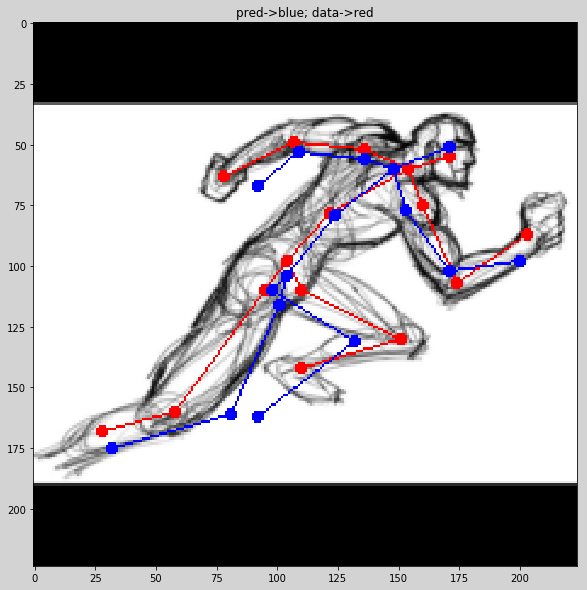

In [16]:
img = plot_pred_and_data_skeleton(y_pred_before, y_data_before, img_name, filename='before')

# Оптимизируем модель под рисунок

In [17]:
loss_mse = torch.nn.MSELoss()

In [18]:
C = 1000
lr = 1e-6
EPOCHS = 40

In [19]:
optimizer = optim.SGD(model_hmr.parameters(), lr=lr) # 6

scheduler = ReduceLROnPlateau(optimizer, 'min', factor = 0.5, 
                              verbose=True, patience=2)

In [20]:
list_loss=[]
for epoch in range(EPOCHS):  
    optimizer.zero_grad()
    y_pred, y_data = get_pred_and_data(img_name, model_hmr)
    loss_value = loss_mse(y_pred, y_data) + C*loss_parallel(y_pred, y_data)
    epoch_loss = loss_value.item()
    loss_value.backward() 
    optimizer.step()
    scheduler.step(epoch_loss)
    print('Epoch_loss : ', epoch_loss)
    list_loss.append(epoch_loss)
    
print('Finished Training')

Epoch_loss :  1050.664794921875
Epoch_loss :  663.5906982421875
Epoch_loss :  475.6505432128906
Epoch_loss :  368.99871826171875
Epoch_loss :  301.5572509765625
Epoch_loss :  254.8062286376953
Epoch_loss :  220.4261474609375
Epoch_loss :  193.70681762695312
Epoch_loss :  171.82757568359375
Epoch_loss :  153.51220703125
Epoch_loss :  138.2920684814453
Epoch_loss :  125.4789047241211
Epoch_loss :  114.52436828613281
Epoch_loss :  104.818115234375
Epoch_loss :  96.27045440673828
Epoch_loss :  88.7510986328125
Epoch_loss :  82.18822479248047
Epoch_loss :  76.3813705444336
Epoch_loss :  71.26345825195312
Epoch_loss :  66.76586151123047
Epoch_loss :  62.7573127746582
Epoch_loss :  59.18631362915039
Epoch_loss :  55.956275939941406
Epoch_loss :  53.06001281738281
Epoch_loss :  50.451263427734375
Epoch_loss :  48.069419860839844
Epoch_loss :  45.89739990234375
Epoch_loss :  43.909645080566406
Epoch_loss :  42.08135223388672
Epoch_loss :  40.39049530029297
Epoch_loss :  38.827964782714844
Epoch

In [21]:
list_loss[0], list_loss[-1]

(1050.664794921875, 29.15426254272461)

In [22]:
with torch.no_grad():
    y_pred_after, y_data_after = get_pred_and_data(img_name, model_hmr)

# Сравниваем до и после

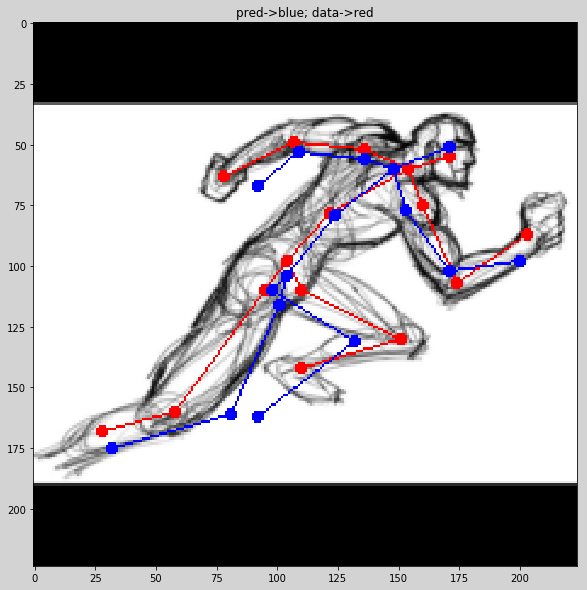

In [23]:
img_before = plot_pred_and_data_skeleton(y_pred_before, y_data_before, img_name,filename='after')

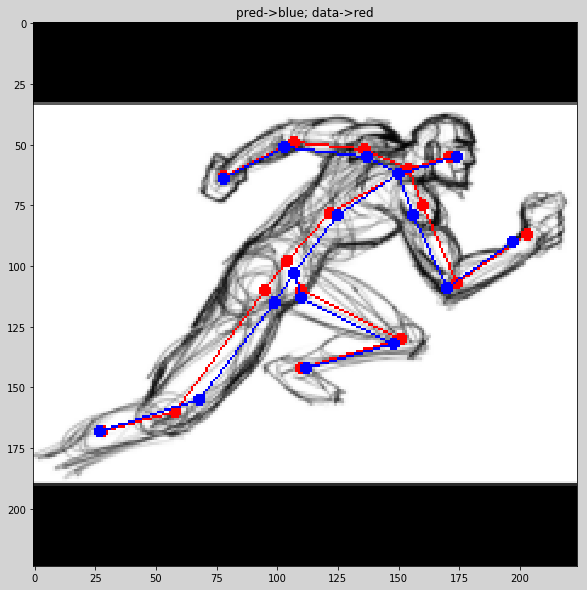

In [24]:
img_after = plot_pred_and_data_skeleton(y_pred_after, y_data_after, img_name,filename='after')

In [27]:
plot_3D(img_name, model_hmr)

# Если хотим сохранить изображения

In [25]:
save_dir = 'results/'

In [25]:
fig, ax = plt.subplots(facecolor='lightgray',figsize=(16,10))
ax.imshow(img_before)
plt.title('pred->blue; data->red')
path = save_dir+'/skeleton_before.png'
plt.savefig(path)
plt.show()

In [26]:
fig, ax = plt.subplots(facecolor='lightgray',figsize=(16,10))
ax.imshow(img_after)
plt.title('pred->blue; data->red')
plt.savefig(path)
plt.show()
path = save_dir+'/skeleton_after.png'
plt.savefig(path)
plt.show()